In [4]:
import torch
import torch.nn as torch
from torch.utils.data import Dataset,DataLoader
import os
import json
from PIL import Image
from torchvision import transforms
import torch
from evaluator import evaluation_model 
from torchvision.utils import save_image




In [5]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self,img_shape,c_dim):
        super(Discriminator, self).__init__()
        self.H,self.W,self.C=img_shape #(,64,64,3)
        self.conditionExpand=nn.Sequential(
            nn.Linear(24,self.H*self.W*1),#(24,64*64)
            nn.LeakyReLU()
        )
        kernel_size=(4,4)
        channels=[4,64,128,256,512]
        for i in range(1,len(channels)):
            setattr(self,'conv'+str(i),nn.Sequential(
                nn.Conv2d(channels[i-1],channels[i],kernel_size,stride=(2,2),padding=(1,1)),
                nn.BatchNorm2d(channels[i]),
                nn.LeakyReLU()
            ))
        self.conv5=nn.Conv2d(512,1,kernel_size,stride=(1,1))
        self.sigmoid=nn.Sigmoid()

    def forward(self,X,c):
        """
        :param X: (batch_size,3,64,64) tensor
        :param c: (batch_size,24) tensor
        :return: (batch_size) tensor
        """
        c=self.conditionExpand(c).view(-1,1,self.H,self.W)
        out=torch.cat((X,c),dim=1)  # become(N,4,64,64)#(b,3,64,64)+(b,1,64,64)
        out=self.conv1(out)  # become(N,64,32,32)
        out=self.conv2(out)  # become(N,128,16,16)
        out=self.conv3(out)  # become(N,256,8,8)
        out=self.conv4(out)  # become(N,512,4,4)
        out=self.conv5(out)  # become(N,1,1,1)
        out=self.sigmoid(out)  # output value between [0,1]
        out=out.view(-1)
        return out

    def weight_init(self,mean,std):
        for m in self._modules:
            #這邊可以改一下初始化的策略 -> conv2d:mean=0 and norm2d:mean=1
            if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
                self._modules[m].weight.data.normal_(mean, std)
                self._modules[m].bias.data.zero_()

class Generator(nn.Module):
    def __init__(self,z_dim,c_dim): # z_dim=100, c_dim=200
        super(Generator,self).__init__()
        self.z_dim=z_dim
        self.c_dim=c_dim
        self.conditionExpand=nn.Sequential(
            nn.Linear(24,c_dim),
            nn.ReLU()
        )
        kernel_size=(4,4)
        channels=[z_dim+c_dim,512,256,128,64]
        paddings=[(0,0),(1,1),(1,1),(1,1)]
        for i in range(1,len(channels)):
            setattr(self,'convT'+str(i),nn.Sequential(
                nn.ConvTranspose2d(channels[i-1],channels[i],kernel_size,stride=(2,2),padding=paddings[i-1]),
                nn.BatchNorm2d(channels[i]),
                nn.ReLU()
            ))
        self.convT5=nn.ConvTranspose2d(64,3,kernel_size,stride=(2,2),padding=(1,1))
        self.tanh=nn.Tanh()

    def forward(self,z,c):
        """
        :param z: (batch_size,100) tensor
        :param c: (batch_size,24) tensor
        :return: (batch_size,3,64,64) tensor
        """
        z=z.view(-1,self.z_dim,1,1)#(b,100,1,1)
        c=self.conditionExpand(c).view(-1,self.c_dim,1,1)#(b,200,1,1)
        out=torch.cat((z,c),dim=1)  # become(N,z_dim+c_dim,1,1)
        out=self.convT1(out)  # become(N,512,4,4)
        out=self.convT2(out)  # become(N,256,8,8)
        out=self.convT3(out)  # become(N,128,16,16)
        out=self.convT4(out)  # become(N,64,32,32)
        out=self.convT5(out)  # become(N,3,64,64)
        out=self.tanh(out)    # output value between [-1,+1]
        return out

    def weight_init(self,mean,std):
        for m in self._modules:
            #這邊可以改一下初始化的策略 -> conv2d:mean=0 and norm2d:mean=1
            if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
                self._modules[m].weight.data.normal_(mean, std)
                self._modules[m].bias.data.zero_()

In [3]:
class CLEVRDataset(Dataset):
    def __init__(self,img_path,json_path):
        """
        :param img_path: file of training images
        :param json_path: train.json
        """
        self.img_path=img_path
        self.max_objects=0
        with open(os.path.join('objects.json'),'r') as file:
            self.classes = json.load(file)
        self.numclasses=len(self.classes)
        self.img_names=[]
        self.img_conditions=[]
        with open(json_path,'r') as file:
            dict=json.load(file)
            for img_name,img_condition in dict.items():
                self.img_names.append(img_name)
                self.max_objects=max(self.max_objects,len(img_condition))
                self.img_conditions.append([self.classes[condition] for condition in img_condition])
        self.transformations=transforms.Compose([transforms.Resize((64,64)),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img=Image.open(os.path.join(self.img_path,self.img_names[index])).convert('RGB')
        img=self.transformations(img)
        condition=self.int2onehot(self.img_conditions[index])
        return img,condition

    def int2onehot(self,int_list):
        onehot=torch.zeros(self.numclasses)
        for i in int_list:
            onehot[i]=1.
        return onehot
        


In [ ]:
torch.manual_seed(9)
lr=0.0002
z_dim=100
c_dim=200
epochs=1000

batch_size=256
scorelist=[]
scorelist2=[]
def train(dataloader,g_model,d_model,z_dim,epochs,lr):
    """
    :param z_dim: 100
    """
    Criterion=nn.BCELoss()
    optimizer_g=torch.optim.Adam(g_model.parameters(),lr,betas=(0.5,0.99))
    optimizer_d=torch.optim.Adam(d_model.parameters(),lr,betas=(0.5,0.99))
    model_evaluator=evaluation_model()

    test_conditions=get_test_conditions(os.path.join('test.json')).to(device)
    new_test_conditions=get_test_conditions(os.path.join('new_test.json')).to(device)
    fixed_z = torch.randn(len(test_conditions), z_dim).to(device)
    best_score = 0

    for epoch in range(1,1+epochs):
        total_loss_g=0
        total_loss_d=0
        for i,(images,conditions) in enumerate(dataloader):
            g_model.train()
            d_model.train()
            batch_size=len(images)
            images = images.to(device)
            conditions = conditions.to(device)

            real = torch.ones(batch_size).to(device)
            fake = torch.zeros(batch_size).to(device)
            
            """
            train discriminator
            """

            optimizer_d.zero_grad()

            # for real images
            predicts = d_model(images, conditions)
            loss_real = Criterion(predicts, real)
            # for fake images
            z = torch.randn(batch_size, z_dim).to(device)
            # 產生fake imgae時，隨機生成latent vector但condition不是隨機生成，
            # 而是拿training data中已經有的condition，
            # 自己隨機生成的condition vector(24dim中會有1~3個1)反而會train壞掉。
            gen_imgs = g_model(z,conditions)
            # gen_imgs.detach() 是為了不要讓BP去跟新到Generator的參數
            predicts = d_model(gen_imgs.detach(), conditions)
            loss_fake = Criterion(predicts, fake)
            # bp
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()

            """
            train generator
            """
            for _ in range(4):
                optimizer_g.zero_grad()

                z = torch.randn(batch_size,z_dim).to(device)
                gen_imgs = g_model(z, conditions)
                predicts = d_model(gen_imgs,conditions)
                loss_g = Criterion(predicts,real)
                # bp
                loss_g.backward()
                optimizer_g.step()

            print(f'epoch{epoch} {i}/{len(dataloader)}  loss_g: {loss_g.item():.3f}  loss_d: {loss_d.item():.3f}')
            total_loss_g+=loss_g.item()
            total_loss_d+=loss_d.item()

        # evaluate
        g_model.eval()
        d_model.eval()
        with torch.no_grad():
            gen_imgs=g_model(fixed_z,test_conditions)
            gen_imgs2=g_model(fixed_z,new_test_conditions)
        score=model_evaluator.eval(gen_imgs,test_conditions)
        score2=model_evaluator.eval(gen_imgs2,new_test_conditions)
        scorelist.append(score)
        scorelist2.append(score2)
        if score>best_score:
            print(score)
            best_score=score
            torch.save(g_model.state_dict(),'g_model.pth')
            torch.save(d_model.state_dict(),'d_model.pth')
        
        if (score>0.7 and score2>0.7):
            break
            # best_g_model_wts=copy.deepcopy(g_model.state_dict())
            # best_d_model_wts=copy.deepcopy(d_model.state_dict())
            # torch.save(best_g_model_wts,os.path.join('models_0614/generator',f'epoch{epoch}_score{score:.2f}.pt'))
            # torch.save(best_d_model_wts,os.path.join('models_0614/discriminator',f'epoch{epoch}_score{score:.2f}.pt'))
        print(f'avg loss_g: {total_loss_g/len(dataloader):.3f}  avg_loss_d: {total_loss_d/len(dataloader):.3f}')
        print(f'testing score: {score:.2f}')
        print('---------------------------------------------')
        # savefig
        if (epoch%10==0):
            save_image(gen_imgs, os.path.join('results_0614', f'epoch{epoch}.png'), nrow=8, normalize=True)

def get_test_conditions(path):
    """
    :return: (#test conditions,#classes) tensors
    """
    with open(os.path.join('objects.json'), 'r') as file:
        classes = json.load(file)
    with open(path,'r') as file:
        test_conditions_list=json.load(file)

    labels=torch.zeros(len(test_conditions_list),len(classes))
    for i in range(len(test_conditions_list)):
        for condition in test_conditions_list[i]:
            labels[i,int(classes[condition])]=1.

    return labels

if __name__=='__main__':

    image_shape=(64,64,3)
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # load training data
    dataset_train=CLEVRDataset(img_path='../iclevr', json_path='train.json')
    loader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=6)

    # create generate & discriminator
    generator=Generator(z_dim,c_dim).to(device)
    discrimiator=Discriminator(image_shape,c_dim).to(device)
    generator.weight_init(mean=0,std=0.02)
    discrimiator.weight_init(mean=0,std=0.02)

    # train
    train(loader_train,generator,discrimiator,z_dim,epochs,lr)

In [52]:
torch.manual_seed(6)
new_test_conditions=get_test_conditions(os.path.join('test.json')).to(device)

new_fixed_z = torch.randn(len(new_test_conditions), z_dim).to(device)
new_gmodel=Generator(z_dim,c_dim).to(device)
new_gmodel.load_state_dict(torch.load('g_model.pth'))
image_shape=(64,64,3)
new_discrimiator=Discriminator(image_shape,c_dim).to(device).to(device)
new_discrimiator.load_state_dict(torch.load('d_model.pth'))
new_gmodel.eval()
new_discrimiator.eval()
model_evaluator=evaluation_model()
gen_imgs2=new_gmodel(new_fixed_z,new_test_conditions)
score2=model_evaluator.eval(gen_imgs2,new_test_conditions)
print(score2)

0.7361111111111112


In [53]:
torch.manual_seed(7)
new_test_conditions=get_test_conditions(os.path.join('new_test.json')).to(device)
print(new_test_conditions.shape)
new_fixed_z = torch.randn(len(new_test_conditions), z_dim).to(device)
new_gmodel=Generator(z_dim,c_dim).to(device)
new_gmodel.load_state_dict(torch.load('g_model.pth'))
image_shape=(64,64,3)
new_discrimiator=Discriminator(image_shape,c_dim).to(device).to(device)
new_discrimiator.load_state_dict(torch.load('d_model.pth'))
new_gmodel.eval()
new_discrimiator.eval()
model_evaluator=evaluation_model()
gen_imgs=new_gmodel(new_fixed_z,new_test_conditions)
score=model_evaluator.eval(gen_imgs,new_test_conditions)
print(score)

torch.Size([32, 24])
0.5952380952380952


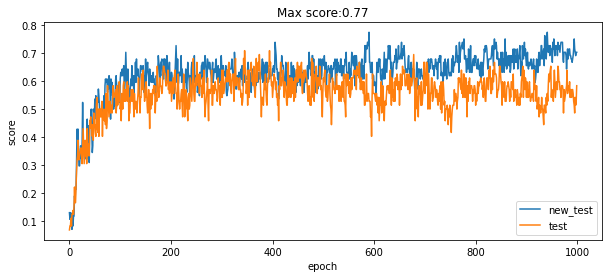

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.title('Max score:0.77')
plt.plot(range(epochs),scorelist2,label='new_test')
plt.plot(range(epochs),scorelist,label='test')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend()

                                                                                           